In [1]:
!nvidia-smi

Wed Jan 26 07:22:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


#Mount Google drive and Extract the Dataset

In [2]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [2]:
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [7]:
# this is where the dataset is stored within the Google Drive 
!ls /mydrive/Nafith_project/

 dataset      'output_video1 -Output-WSize 25.mp4'
 dataset.zip  'output_video -Output-WSize 25.mp4'
 demo.mkv      saved_model


In [3]:
#unzip the dataset 
!unzip /content/gdrive/MyDrive/Nafith_project/dataset.zip -d /content/gdrive/MyDrive/Nafith_project

#Splitting the dataset into train and test  



In [6]:
rootdir= '/content/gdrive/MyDrive/Nafith_project/dataset' 
classes = ['bus', 'car', 'truck']

for i in classes:

  os.makedirs(rootdir +'/train/' + i)

  os.makedirs(rootdir +'/test/' + i)

  source = rootdir + '/' + i

  allFileNames = os.listdir(source)

  np.random.shuffle(allFileNames)

  test_ratio = 0.25

  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                      [int(len(allFileNames)* (1 - test_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train/' + i)

  for name in test_FileNames:
    shutil.copy(name, rootdir +'/test/' + i)


In [7]:
train = '/content/gdrive/MyDrive/Nafith_project/dataset/train'
test = '/content/gdrive/MyDrive/Nafith_project/dataset/test'

#Importing all important libraries 

In [3]:
import os
import cv2
import math
import random
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
import shutil
%matplotlib inline
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4055040/45929032 bytes (8.8%)7954432/45929032 bytes (17.3%)12181504/45929032 bytes (26.5%)16130048/45929032 bytes (35.1%)20217856/45929032 bytes (44.0%)24354816/45929032 bytes (53.0%)28467200/45929032 bytes (62.0%)32464896/45929032 bytes (70.7%)36569088/45929032 bytes (79.6%)40771584/45929032 bytes (88.8%)44851200/45929032 bytes (97.7%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

#Visualizing the Data

['bus', 'car', 'truck']
displaying one image of each class


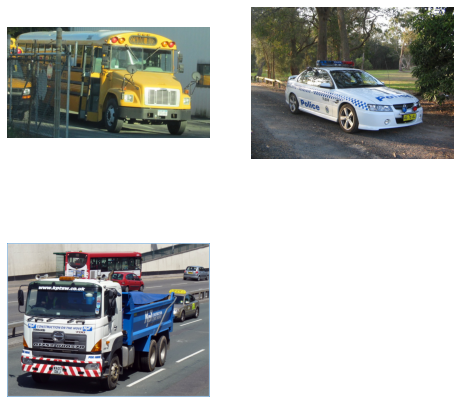

In [13]:
def visualize():

  '''displaying one image of each class'''

  fig = plt.figure(figsize=(8, 8))
  all_classes_names = os.listdir('/content/gdrive/MyDrive/Nafith_project/dataset/train/')
  print(all_classes_names)


  for i in range(0 , len(all_classes_names)):
      file = os.path.join('/content/gdrive/MyDrive/Nafith_project/dataset/train/' , all_classes_names[i])
      file_contant = os.listdir(file)
      painting=plt.imread( file + "/" + file_contant[0])
      fig.add_subplot(2, 2, i+1)
      plt.imshow(painting)
      plt.axis('off')

visualize()
print(visualize.__doc__)

car
Displaying the first frame of our video


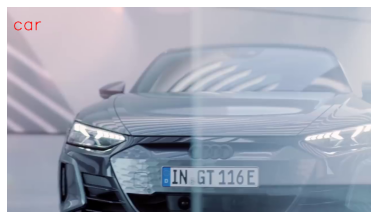

In [14]:
def first_frame():

  '''Displaying the first frame of our video'''

  plt.figure(figsize = (30, 30))

  # Get Names of all classes in our train dataset
  all_classes_names = os.listdir('/content/gdrive/MyDrive/Nafith_project/dataset/train')

  selected_class_Name = all_classes_names[1]
  print(selected_class_Name)

  # Reading the Video File Using the Video Capture method 
  video_reader = cv2.VideoCapture(f'/content/gdrive/MyDrive/Nafith_project/demo.mkv')
    
  # Reading The First Frame of the Video File
  v, bgr_frame = video_reader.read()

  # Closing the VideoCapture object 
  video_reader.release()

  # Converting the BGR Frame to RGB Frame 
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # Adding The Class Name Text on top of the Video Frame.
  cv2.putText(rgb_frame, selected_class_Name, (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)
    
  # Assigning the Frame to a specific position of a subplot
  plt.subplot(5, 4, 1)
  plt.imshow(rgb_frame)
  plt.axis('off')

first_frame()
print(first_frame.__doc__)

#Data Augmentation

In [32]:
image_height, image_width = 128, 128
classes_list = ["bus", "car", "truck"]
model_output_size = len(classes_list)

train_batches = ImageDataGenerator(
                                   rotation_range = 15,
                                   rescale = 1. / 255,
                                   shear_range = 0.1,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1) \
  .flow_from_directory(directory='/content/gdrive/MyDrive/Nafith_project/dataset/train', target_size=(image_height, image_width), classes=classes_list, batch_size=8,)

test_batches = ImageDataGenerator() \
    .flow_from_directory(directory= '/content/gdrive/MyDrive/Nafith_project/dataset/test'
, target_size=(image_height, image_width), classes=classes_list, shuffle=False)

Found 1897 images belonging to 3 classes.
Found 634 images belonging to 3 classes.


#Model Architecture

In [33]:
def create_model():

    #construct the model by using a Sequential model

    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(3, activation = 'softmax'))

    # Printing the models summary
    model.summary()
    return model

# Calling the create_model method
model = create_model()
print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 batch_normalization_6 (Batc  (None, 124, 124, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                      

#checkpoint to Save the model

In [34]:
checkpoint_path = "/content/gdrive/MyDrive/Nafith_project/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [35]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [ ]:
# # Adding Early Stopping Callback
# early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# # Adding loss, optimizer and metrics values to the model.
# model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training proccess


In [25]:
model_training_history = model.fit(train_batches, validation_data= test_batches , epochs = 50,  callbacks = [cp_callback])


Epoch 1/50
238/238 [==============================] - ETA: 0s - loss: 1.0843 - accuracy: 0.4365
Epoch 00001: saving model to /content/gdrive/MyDrive/Nafith_project/cp.ckpt
238/238 [==============================] - 583s 2s/step - loss: 1.0843 - accuracy: 0.4365 - val_loss: 319.4769 - val_accuracy: 0.3423
Epoch 2/50
238/238 [==============================] - ETA: 0s - loss: 1.0478 - accuracy: 0.4697
Epoch 00002: saving model to /content/gdrive/MyDrive/Nafith_project/cp.ckpt
238/238 [==============================] - 47s 198ms/step - loss: 1.0478 - accuracy: 0.4697 - val_loss: 606.3195 - val_accuracy: 0.4274
Epoch 3/50
238/238 [==============================] - ETA: 0s - loss: 1.0422 - accuracy: 0.4729
Epoch 00003: saving model to /content/gdrive/MyDrive/Nafith_project/cp.ckpt
238/238 [==============================] - 47s 198ms/step - loss: 1.0422 - accuracy: 0.4729 - val_loss: 1661.2456 - val_accuracy: 0.2287
Epoch 4/50
238/238 [==============================] - ETA: 0s - loss: 1.0361 

In [134]:
os.listdir(checkpoint_dir)

#Re-evaluate the model

In [36]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_batches,  verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

20/20 - 10s - loss: 475.0255 - accuracy: 0.5095 - 10s/epoch - 494ms/step
Restored model, accuracy: 50.95%


In [30]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
predictions = model.predict(x=test_batches)
print(f' Accuracy: {accuracy_score(test_batches.classes, np.argmax(predictions, axis=-1))}')


 Accuracy: 0.5094637223974764


#Plotting the model accuracy versus total validation loss

In [25]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  
  #To plot the Total loss & Total accuracy vs Total Validation Loss

  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

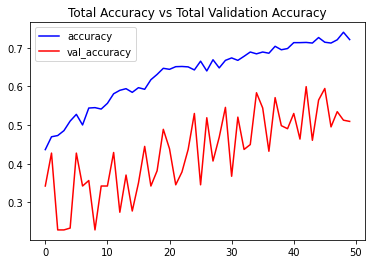

In [38]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
model.save('/content/gdrive/MyDrive/Nafith_project/'+'saved_model')


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Nafith_project/saved_model/assets


In [ ]:
sequence_model  = keras.models.load_model('/content/gdrive/MyDrive/Nafith_project/'+'saved_model')


#Video classification and analysis

In [44]:
def predict_on_video(video_file_path, output_file_path, window_size):

    count_car = 0 
    count_bus = 0 
    count_truck = 0 
    #Initializing a Deque with a fixed size that will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture 
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_width, original_height))

    while True: 

        #Reading The Frame
        status, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not status:
            break

        #Resizing the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        #Normalizing the resized frame by dividing it with 255 to convert pixel values between 0 and 1
        normalized_frame = resized_frame / 255

        #Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        #Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        #Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            #Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            #Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            #Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)
            
            #Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]

            #Overlaying Class Name and its count Ontop of the Frame
            if (predicted_class_name == 'car'): 
              count_car += 1
              cv2.putText(frame, predicted_class_name +  str(count_car), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            elif (predicted_class_name =='bus'):
              count_bus += 1
              cv2.putText(frame, predicted_class_name + str(count_bus), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            elif (predicted_class_name =='truck'): 
              count_truck += 1
              cv2.putText(frame, predicted_class_name + str(count_truck), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)


            #Saving one frame of each object in seperate folder
            for i in range (0,3):  
               if (predicted_class_name == 'car'): 
                   cv2.imwrite(os.path.join('/content/gdrive/MyDrive/Nafith_project/car_frame/' +'car.jpg'),frame)
               elif(predicted_class_name =='bus'):
                    cv2.imwrite(os.path.join('/content/gdrive/MyDrive/Nafith_project/bus_frame/'+'bus.jpg'),frame)
               elif(predicted_class_name =='truck'): 
                    cv2.imwrite(os.path.join('/content/gdrive/MyDrive/Nafith_project/truck_frame/'+'truck.jpg'),frame)
                    
        # Writing The Frame
        video_writer.write(frame)

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()
    print('number of car= ' + str(count_car))
    print('number of bus= ' + str(count_bus))
    print('number of truck= ' + str(count_truck))

In [45]:
#Creating The Output directories 
output_directory = '/content/gdrive/MyDrive/Nafith_project'

#Setting video_title 
video_title = 'output_video2'


In [46]:
#Setting the Window Size that will be used by the Average Process
window_size = 25

#Constructing The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

#Calling the predict_on_live_video method to start the Prediction and Rolling Average Process
predict_on_video('/content/gdrive/MyDrive/Nafith_project/demo.mkv', output_video_file_path, window_size)

number of car= 1897
number of bus= 1602
number of truck= 33


In [17]:
# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)